In [1]:
import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as Model

In [2]:
# investment_decisions:

nopinions = [50, 50]

# Parameters:

phi, b_d = 0.4, 1.25

input_parameters = {'b_c': 1., 'phi': phi, 'tau': 1.,
                    'eps': 0.01, 'b_d': b_d, 'e': 100.,
                    'b_r0': 0.1 ** 2 * 100.,
                    'possible_opinions': [[0], [1]],
                    'xi': 1. / 8., 'beta': 0.06,
                    'L': 100., 'C': 100., 'G_0': 800.,
                    'campaign': False, 'learning': True,
                    'R_depletion': False, 'test': True,
                    'interaction': 1, 'crs': True}

# investment_decisions
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# investment
clean_investment = np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)
m = Model(*init_conditions)

/home/jakob/anaconda3/envs/pyds/lib/python3.6/site-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/home/jakob/anaconda3/envs/pyds/lib/python3.6/site-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


In [3]:
DSargs = pdt.args(name='aggregated_approximation')
v_e, v_pi, v_tau = sp.symbols('v_e v_pi v_tau')
v_K_cc, v_K_cd, v_K_dc, v_K_dd = sp.symbols('K_cc K_cd K_dc K_dd')
v_subs = {m.e: v_e, m.pi: v_pi, m.tau: v_tau,
          m.Kcc: v_K_cc, m.Kcd: v_K_cd, 
          m.Kdc: v_K_dc, m.Kdd: v_K_dd}

equations = {m.var_symbols[i]: str(m.rhs_raw[i].subs(v_subs)) for i in range(len(m.var_names))}

equations_updated = {}
for (symbol, value) in equations.items():
    if symbol in v_subs.keys():
        equations_updated[str(v_subs[symbol])] = value
    else:
        equations_updated[str(symbol)] = value
        


params_updated = {}
for (symbol, value) in m.list_parameters().items():
    if symbol in v_subs.keys():
        params_updated[str(v_subs[symbol])] = value
    else:
        params_updated[str(symbol)] = value



initial_conditions = {}
for (symbol, value) in m.list_initial_conditions().items():
    if symbol in v_subs.keys():
        initial_conditions[str(v_subs[symbol])] = value
    else:
        initial_conditions[str(symbol)] = value   
    

del equations_updated['G']
del initial_conditions['G']
params_updated['G'] = m.p_G_0

params_updated['xi'] = 0.15
params_updated['epsilon'] = 0.001
params_updated['phi'] = .4

initial_conditions['C'] = 50

DSargs.pars = params_updated
DSargs.varspecs = equations_updated
DSargs.ics = initial_conditions
DSargs.tdata = [0, 500]
DSargs.algparams = {'init_step': 0.2}

In [4]:
ode = pdt.Generator.Vode_ODEsystem(DSargs)

In [5]:
traj = ode.compute('some name?')

In [6]:
pts = traj.sample(dt=1.)

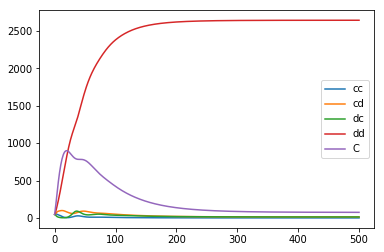

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pts['t'], pts['K_cc'], label='cc')
ax.plot(pts['t'], pts['K_cd'], label='cd')
ax.plot(pts['t'], pts['K_dc'], label='dc')
ax.plot(pts['t'], pts['K_dd'], label='dd')
ax.plot(pts['t'], pts['C'], label='C')
plt.legend()


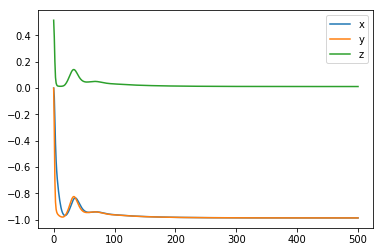

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(pts['t'], pts['K_cc'], label='cc')
ax.plot(pts['t'], pts['x'], label='x')
ax.plot(pts['t'], pts['y'], label='y')
ax.plot(pts['t'], pts['z'], label='z')
plt.legend()

In [9]:
ode.set(ics=pts[-1])

In [10]:
PC = pdt.ContClass(ode)
PCargs = pdt.args(name='EQ1', type='EP-C')
PCargs.freepars = ['xi']
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 2
PCargs.MinStepSize = 1e-10
PCargs.StepSize = 2e-3
PCargs.SaveEigen = True
PCargs.LocBifPoints = 'LP'

In [11]:
PC.newCurve(PCargs)
PC['EQ1'].forward()

LP Point found 


Text(0.5,0,'$\\xi$')

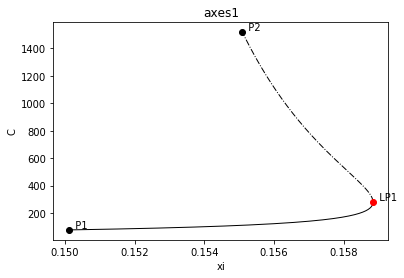

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
PC['EQ1'].display(stability=True)
ax.set_xlabel(r'$\xi$')

In [ ]:
PCargs = pdt.args(name='SN1', type='EP-C', force=True)
PCargs.initpoint = 'EQ1:LP1'
PCargs.freepars = ['phi']
PCargs.MaxNumPoints = 2000
PCargs.MaxStepSize = 1
PCargs.MinStepSize = 1e-16
PCargs.StepSize = 2e-5
PCargs.SaveEigen = True
PCargs.LocBifPoints = 'LP'

In [ ]:
PC.newCurve(PCargs)
PC['SN1'].forward()

In [ ]:
PC['SN1'].display(stability=True)